# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

## <font style="color:green">Class_counts: (very uneven)</font>
* id: 0 'githeri': 479,
* id: 1 'ugali': 628,
* id: 2 'kachumbari': 494,
* id: 3 'matoke': 483,
* id: 4 'sukumawiki': 402,
* id: 5 'bhaji': 632,
* id: 6 'mandazi': 620,
* id: 7 'kukuchoma': 173,
* id: 8 'nyamachoma': 784,
* id: 9 'pilau': 329,
* id:10 'chapati': 862,
* id:11 'masalachips': 438,
* id:13 'mukimo': 212

Name: class, dtype: int64, sum: 6536



In [1]:
%matplotlib inline

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.4 MB/s eta 0:00:0000:0100:01


In [3]:
# Import neccesaary libraries
import os
import time
import collections
from dataclasses import dataclass
import sys

# third party library
import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image


# Pytorch related
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim import SGD  
from torch.optim import Adam
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet152, resnet18

In [4]:
print(torch.__version__)
torch.cuda.device_count()
torch.cuda.get_device_name()
torch.cuda.is_available()
print(torch.cuda.get_device_capability())

1.11.0
(6, 0)


In [5]:
# all the Transforms
# def resize_preprocess():
#     """Compulsory transforms image to same_size and center cropped (not changing to Tensor yet)"""
#     resize_preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#     ])
    
#     return resize_preprocess


def small_image_preprocess_transforms():
    """pre_process for KenyanFood13Testset holding original database(No need to hold big image)"""
    small_image_preprocess = transforms.Compose([
        transforms.Resize(1),
        transforms.ToTensor()
    ])
    
    return small_image_preprocess


### from here to below will change to Tensor
def image_preprocess_transforms():
    """pre_process for KenyanFood13Testset """
    image_preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    return image_preprocess


def train_preprocess():
    """resize_preprocess() + couple transformation to improve accuracy in training, ToTensor and Normalization"""
    transforms_train = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # Somehow this doesn't work
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio = (0.33, 0.33), value= 0, inplace = False), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomPosterize(bits=2),
        transforms.ToTensor(),
        transforms.Normalize(tc.mean, tc.std)        
    ])
    return transforms_train
    
    
def validation_preprocess():
    validation_train = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(tc.mean, tc.std)
    ])
    return validation_train


In [6]:
# Datasets Classes
class KenyanFood13Dataset(Dataset):
    """create KenyanFood Dataset from annotations_file and images"""
    def __init__(self, transform = None):
        self.img_labels = pd.read_csv(tc.annotation_file)
        self.img_dir = tc.img_dir
        # Make list of the classes list will give index (iterable) -> 13 classes
        self.classes = list(self.img_labels['class'].unique()) 
        # Make dictionary set of the classes 
        self.dict_classes = dict(enumerate(self.img_labels['class'].unique()))
        self.transform = transform
        
        # weigths of each class normalized (total = 1.0)
        def _inverse_ratio():
            """calculate inverse ratio of number of each classes for weighted sampler usage"""
            series = self.img_labels['class'].value_counts()
            total = series.sum()
            for index, _ in enumerate(series):
                series.iloc[index] = series.iloc[index]/total
            return series
        
        # This inner method won't work for inheritance since it is inside __init__()
        def _calc_sample_weights():
            class_counts = self.img_labels['class'].value_counts()
            sample_weights = [1/class_counts[i] for i in self.img_labels['class']]
            return sample_weights
        
        # sample_weights
        self.samples_weights = [self.img_labels['class'].value_counts()[i] for i in self.img_labels['class']]       
    
    # need this method to get original dataset image_labels from child class
    def _get_img_labels(self):
        return self.img_labels  
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        """Return (image, target) after resizing and preprocessing 
        iloc[index, 0] will return ids (e.g.,14278962987112149800) of each row"""
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[index, 0])+".jpg")     
        image = Image.open(img_path)

        # label is string so will return index (pytorch cannot make string to tensor)
        # iloc[index, 1] will return the class_name (e.g., githeri) for id in [index, 1] (e.g., 14278962987112149800)
        label_index = self.class2index(self.img_labels.iloc[index, 1])  # returns int

        if self.transform:
            image = self.transform(image)

        return image, label_index #image: Image or Tensor ,  label_index: int -> Does this needs to be Tensor?
    
    
    def class2index(self, class_name:str)-> int:
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    
    def index2class(self, class_index:int)-> str:
        """Returns the class of a given index."""
        return self.classes[class_index]


class KenyanFood13SplitDataset(KenyanFood13Dataset):
    def __init__(self, transform = None, train= True):
        # above __init__() will override super class init(), so needs to call super()__init__ for initialization
        super().__init__(transform = transform)
        #self.img_labels = None
#       print(f"self.img_labels in __init()__ first: {self.img_labels}\n") # 6536

        # need this method to get original dataset image_labels
        image_labels = super()._get_img_labels()

        # Overrides self.img_labels by ratio of split
        if train:
            self.img_labels = image_labels.iloc[:int(len(image_labels) * tc.train_split)]
        else: #for validation
            self.img_labels = image_labels.iloc[int(len(image_labels) * tc.train_split):]
        
        # Override the sample_weights since train database has splitted database, needed for weighted Random Sampler
        self.samples_weights = [self.img_labels['class'].value_counts()[i] for i in self.img_labels['class']]
    
class KenyanFood13Testset(Dataset):
    """Kenyan food test dataset, contains original KenanFood13Dataset for image2class and class2image methods"""
    def __init__(self, transform = image_preprocess_transforms()):
        self.img_dir = tc.img_dir
        self.test_labels = pd.read_csv(tc.test_csv_file)
        self.transform = transform
        # this is to use class2index() and class2index()
        self.base_dataset = KenyanFood13Dataset(small_image_preprocess_transforms())

    def __getitem__(self, index):
        """Retrieves one item from the dataset."""
        
        # get img path from test_labels. img_dir + id in csv file (per index) + ".jpg" 
        img = os.path.join(self.img_dir, str(self.test_labels.iloc[index, 0]) + '.jpg')
        
        image = Image.open(img)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.test_labels)

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [7]:
# Settings and configurations
@dataclass
class SystemConfiguration:
    seed:int = 42
        
# Specifiy all the data needed in dataclass named TrainingConfiguration
@dataclass
class TrainingConfiguration:
    batch_size: int = 13
    epoch_count: int = 30
    init_learning_rate: float = 0.0001
    lr: float =0.00001
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "/kaggle/input/opencv-pytorch-dl-course-classification/"
    model_dir: str = '/kaggle/working/models/'
    log_dir: str = '/kaggle/working/logs'
    submission_csv: str = '/kaggle/working/submission.csv'
#     submission_csv: str = '/content/submission.csv'
#     data_root: str = "/content/"    
#     model_dir: str = '/content/models/'
#     log_dir: str = '/content/logs'
    annotation_file: str = data_root + "train.csv"
    test_csv_file: str = data_root + "test.csv"
    img_dir: str = data_root + "images/images/"

    num_workers: int = 2
    device: str = 'cpu'
    train_split: float = 0.8
    random_seed: int = 42
    model_name: str = "resnet152"
    res18_layers :tuple = (2,2, 2,2)
    res34_layers :tuple = (3,4, 6,3)
    res50_layers :tuple = (3,4, 6,3)
    res101_layers:tuple = (3,4,23,3)
    res152_layers:tuple = (3,8,36,3)

    classes: tuple = ('githeri', 'ugali', 'kachumbari', 'matoke', 'sukumawiki', 'bhaji', 'mandazi', 'kukuchoma', 'nyamachoma', 'pilau', 'chapati', 'masalachips', 'mukimo')
    dataset_len: int = 6536
    #below is calculated from KenyanFood13 pictures
    #mean: torch.tensor = torch.tensor([0.5768, 0.4622, 0.3460])
    #std: torch.tensor = torch.tensor([0.2699, 0.2739, 0.2826])
    
    #below mean and standard are for Resnet18 https://pytorch.org/hub/pytorch_vision_resnet/
    mean: torch.tensor = torch.tensor([0.485, 0.456, 0.406])
    std: torch.tensor  = torch.tensor([0.229, 0.224, 0.225])
        
    tb_writer: SummaryWriter = SummaryWriter(log_dir)
    criterion: torch.nn.CrossEntropyLoss = torch.nn.CrossEntropyLoss()        

def setup_system(SystemConfiguration):
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        tc.device = torch.device("cuda:0")
        torch.backends.cudnn_benchmark_enabled = True
        torch.backends.cudnn.deterministic = True
        
        
tc = TrainingConfiguration()
system_config = SystemConfiguration()
setup_system(system_config)

for path in [tc.log_dir, tc.model_dir]:
    if not os.path.exists(path):
        os.makedirs(path)
        



In [8]:
sys.setrecursionlimit(10000) 

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [9]:
def train(model, train_loader, optimizer) -> float:
    """train by model by given train_loader(and its datasets) and optimizer, return average loss and accuracy"""
    total_loss = 0.0
    total_acc = 0
    count = 0
    model.to(tc.device)
    model.train()
    
    for inputs, labels in tqdm(train_loader):
        count += len(labels)
        # move to target device (GPU or CPU)
        inputs = inputs.to(tc.device)
        labels = labels.to(tc.device)
        
        # prediction
        outputs = model(inputs)
        # calculate loss
        loss = tc.criterion(outputs, labels)
        # initialize the gradients -> calucalte the gradients -> Update the gradients
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()
        
        # adds up loss pf number of batches
        total_loss += loss.item()
        # calculates accumulative average loss by dividing total loss by length of dataset predicted so far
        avg_loss = total_loss / count
        
        # get highest predicted value
        predicted = torch.max(outputs, axis=1)[1]
        # calculates accumulative average accuracy by dividing total loss by length of dataset predicted so far
        total_acc  += (predicted == labels).sum().item()
        avg_acc =  total_acc / count
        
    return avg_loss, avg_acc

In [10]:
def validate(model, validation_loader):
    """validate by model by given validation_loader(and its datasets) , return average loss"""
    total_loss = 0.0
    total_acc = 0
    count = 0
    model.to(tc.device)
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader):
            count += len(labels)
            # move to target device (GPU or CPU)
            inputs = inputs.to(tc.device)
            labels = labels.to(tc.device)
            
            # prediction
            outputs = model(inputs)
            # calculate loss
            loss = tc.criterion(outputs, labels)
            
            # adds up loss pf number of batches
            total_loss += loss.item()
            # calculates accumulative average loss by dividing total loss by length of dataset predicted so far
            avg_loss = total_loss / count
            
            # get highest predicted value
            predicted = torch.max(outputs, axis=1)[1]
            # calculate number of correct answer
            total_acc  += (predicted == labels).sum().item()
            # calculates accumulative average accuracy by dividing total loss by length of dataset predicted so far
            avg_acc =  total_acc / count
        
            
    return avg_loss, avg_acc
        

In [11]:
def predict(trained_model, prediction_loader) -> list:
    """prediction with model and test_loader, returns list of prediction result, assume to be used for inference ONLY"""  
    predictions = torch.tensor([]).to(tc.device)
    for inputs in prediction_loader:
        inputs = inputs.to(tc.device)
        outputs = trained_model(inputs)
        # get the predicted result by index number, each prediction will be done by tc.batch_size so predicted is array of batch_size
        predictions = torch.hstack((predictions, torch.max(outputs, axis=1)[1]))
        
    return predictions.tolist()


## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [12]:
#implement Resnet from Scratch
# conv3x3 and conv1x1 as static method since used a lot.
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)


In [13]:
class BasicBlock(nn.Module):
    # at the last layer of each block, the channel is x1, for example resnet30 first Bottleneck,
    # 1x1 conv 64 -> 3x3 conv 64
    expansion = 1

    def __init__(self, in_channels, base_channels, stride=1):
        """
        Constructor

        Parameters
        ----------
        in_channels : int
            number of channels for input
        base_channels : int
            number of channels used in this basic block
        stride : int
            stride used in this basic block
        """
        super().__init__()
        self.conv1 = conv3x3(in_channels, base_channels, stride)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)  # inplace=True will directory change the value
        self.conv2 = conv3x3(base_channels, base_channels)
        self.bn2 = nn.BatchNorm2d(base_channels)

        # First residual block's number of input channel and output channel is different (e.g., conv3_x in res18 has input channel as 64 but out put is 128)
        # And also the size (56 x 56 -> 28 x 28),
        if in_channels != base_channels * self.expansion:
            self.shortcut = nn.Sequential(
                conv1x1(in_channels, base_channels * self.expansion, stride=2),  # stride = 2 due to make the size half
                nn.BatchNorm2d(base_channels * self.expansion)
            )
            print(f"self.shortcut for in_channels != channels * self.expansion: {self.shortcut}")
        else:
            self.shortcut = nn.Sequential()
            print(f"self.shortcut for in_channels == channels * self.expansion: {self.shortcut}")

        print(
            f"##### in_channels:{in_channels}  base_channels:{base_channels} conv1 stride: {stride}, self.shortcut {self.shortcut}")

    def forward(self, x):
        """

        Parameters
        ----------
        self
        x

        Returns
        -------

        """
        out = self.conv1(x)
        print(f"conv1(x).size(): {out.shape}")
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        print(f"self.shortcut(x).shape: {self.shortcut(x).shape}")
        print(f"out += self.shortcut(x): {out.shape}")
        out = self.relu(out)

        return out

In [14]:
class Bottleneck(nn.Module):
    # at the last layer of each block, the channel is x4, for example resnet50 first Bottleneck,
    # 1x1 conv 64 -> 3x3 conv 64 -> 1x1 conv 256
    expansion = 4

    def __init__(self, in_channels, base_channels, stride=1):
        """

        Parameters
        ----------
        in_channels
        base_channels
        stride
        """
        super().__init__()
        self.conv1 = conv1x1(in_channels, base_channels)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.conv2 = conv3x3(base_channels, base_channels, stride)
        self.bn2 = nn.BatchNorm2d(base_channels)
        # third one has 4x more channels as out put
        self.conv3 = conv1x1(base_channels, base_channels * self.expansion)
        self.bn3 = nn.BatchNorm2d(base_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != base_channels * self.expansion:
            self.shortcut = nn.Sequential(
                # need stride as parameter since conv2_x is stride=1, and others are 2
                conv1x1(in_channels, base_channels * self.expansion, stride),
                nn.BatchNorm2d(base_channels * self.expansion),
            )
            print(f"self.shortcut for in_channels != channels * self.expansion: {self.shortcut}")
        else:
            self.shortcut = nn.Sequential()
            print(f"self.shortcut for in_channels == channels * self.expansion: {self.shortcut}")

        print(
            f"##### in_channels:{in_channels}  base_channels:{base_channels} conv2 stride: {stride}, self.shortcut {self.shortcut}")

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        print(f"self.shortcut(x).shape: {self.shortcut(x).shape}")
        print(f"out += self.shortcut(x): {out.shape}")

        out = self.relu(out)

        return out

In [15]:

class Resnet(nn.Module):
    def __init__(self, block_type, layers: tuple, num_classes=1000):
        """

        Parameters
        ----------
        block_type: BasicBlock, Bottleneck
            Whether this resnet use BasicBlock (Res18/Res34) or Bottleneck(Res50 or higher)
        layers: tuple
            contains number of covolution in each layer, for example for Resnet50 (3,4,6,4)
        num_classes: int
            number of output classes
        """
        super().__init__()

        self.in_channels = 64  # initial channel for all type is 64

        # initial conv1_x layer, number of input_channel = 3(R,G,B), number of output_channel = 64
        # Input image size 224*224*3(RGB), padding = (3,3) to make size 230 * 230 ->  112*112 with stride (2,2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        # conv2_x layer, input size is (batch_size, 64, 112, 112)
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_x = self._create_layer(block_type, 64, layers[0], stride=1)  # for resnet50 layers[0] = 3
        self.conv3_x = self._create_layer(block_type, 128, layers[1], stride=2)  # for resnet50 layers[1] = 4
        self.conv4_x = self._create_layer(block_type, 256, layers[2], stride=2)  # for resnet50 layers[2] = 6
        self.conv5_x = self._create_layer(block_type, 512, layers[3], stride=2)  # for resnet50 layers[3] = 3
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block_type.expansion, num_classes)

    def _create_layer(self, block_type, base_channels, repeated_conv_blocks, stride):
        """
        create layers, conv2_x, conv3_x, conv4_x and conv5_x in Resnet18, 34, 50, 101 and 152

        Parameters
        ----------
        block_type:BasicBlock, Bottleneck
            Whether this resnet use BasicBlock (Res18/Res34) or Bottleneck(Res50 or higher)
        base_channels: int
            for conv2_x: 64, conv3_x:128 , conv4_x = 256, conv5_x 512. These numbers are common across all Resnet type
        repeated_conv_blocks : int
            number of convolution blocks repeated, for example res50 conv2_x repeats 3 times and conv4_x repeats 6 times
        stride: int or tuple(int,int)

        Returns
        -------
            nn.Sequential
        """
        layers = []

        # first Residual basic block (or bottleneck), constructs basic block (or bottleneck) and appends to list
        layers.append(block_type(self.in_channels, base_channels, stride))
        # rest of Residual basic block
        self.in_channels = base_channels * block_type.expansion
        for _ in range(1, repeated_conv_blocks):
            layers.append(block_type(self.in_channels, base_channels))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [16]:
# Use pretrained one so comment out
# def resnet18():
#     return ResNet(BasicBlock, tc.res18_layers)
# def resnet34():
#     return ResNet(BasicBlock, tc.res34_layers)
# def resnet50():
#     return ResNet(Bottleneck, tc.res50_layers)
# def resnet101():
#     return Resnet(Bottleneck, tc.res101_layers)
# def resnet152():
#     return Resnet(Bottleneck, tc.re152_layers)

In [17]:
# # Resnet 18 (or 152) and change last layer output to 13
# model = resnet152(pretrained = True)
# # Change the last output to 13
# fc_in_features = model.fc.in_features
# model.fc = torch.nn.Linear(fc_in_features, (len(tc.classes)))
# model = model.to(tc.device)


In [18]:
class AdditionalDenseLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier_layer = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),   
            nn.Linear(512, 256),
            nn.Linear(256, len(tc.classes))
        )
    
    def forward(self, x):
        x = self.classifier_layer(x)
        
        return x

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [19]:
## util functions

def get_mean_std(dataset):
    """returns mean and standard deviation of dataset given, since this method will take long time, once calcuated, not been used"""
    # calculated mean: tensor([0.5768, 0.4622, 0.3460]), std:tensor([0.2699, 0.2739, 0.2826]):
    loader = DataLoader(dataset)
    
    batch_mean = torch.zeros(3) # tensor([0,0,0])
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0,2,3))
        batch_mean_sqrd += (batch_data **2).mean(dim=(0,2,3))
        
    mean = batch_mean / len(loader)
    var = (batch_mean_sqrd) / len(loader) - (mean **2)
    
    std = var ** .5
    
    print("mean: {}, std:{}:".format(mean, std))
    return mean, std


def eval_loss(data_loader, device, model, criterion):
    """evaluate losses and can use this for visualize"""
    for images, labales in data_loader:
        break
        
    inputs = images.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    return loss

def evaluate_history(history):
    import matplotlib.pyplot as plt
    print("initial stats: Loss{:.5f}  Accuracy{:.5f}".format(history[0,3], history[0,4]))
    print("final stats: Loss{:.5f}  Accuracy{:.5f}".format(history[-1,3], history[-1,4]))
    
    num_epochs = len(history)
    unit = num_epochs/10
    
    # Display learning curve (Loss)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='train')
    plt.plot(history[:,0], history[:,3], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of iteration')
    plt.ylabel('loss')
    plt.title('learning curve (Loss)')
    plt.legend()
    plt.show()

    # Display learning curve (Accuracy)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='train')
    plt.plot(history[:,0], history[:,4], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of iteration')
    plt.ylabel('loss')
    plt.title('learning curve (Accuracy')
    plt.legend()
    plt.show()


# model save and load functions
def save_model(model, device):
    if not os.path.exists(tc.model_dir):
        os.makedirs(tc.model_dir)
    
    model_path = os.path.join(tc.model_dir, tc.model_name)
    
    if device == "cuda":
        model.to("cpu")
    
    #torch.save(model.state_dict(), model_path + "best_model.pt")
    torch.save(model.state_dict(), os.path.join(tc.model_dir, "best_model.pt"))
    
    if device == "cuda":
        model.to("cuda")
    
    return

def load_model(model):
    
    #model_path = os.path.join(tc.model_dir, tc.model_name)
    model.load_state_dict(torch.load(tc.model_dir + 'best_model.pt'))
    
    return model

* id: 0 'githeri': 479,
* id: 1 'ugali': 628,
* id: 2 'kachumbari': 494,
* id: 3 'matoke': 483,
* id: 4 'sukumawiki': 402,
* id: 5 'bhaji': 632,
* id: 6 'mandazi': 620,
* id: 7 'kukuchoma': 173,
* id: 8 'nyamachoma': 784,
* id: 9 'pilau': 329,
* id:10 'chapati': 862,
* id:11 'masalachips': 438,
* id:13 'mukimo': 212

In [20]:
#tools to use matplot to visualize data balanced each batch
def visualize_batch_data(dataloader, with_visual_chart = True , with_class_string = True) -> dict:
    """visualize what class is in the batch to visually see the equalness of the samples"""
    #{0: 'githeri', 1: 'ugali', 2: 'kachumbari', 3: 'matoke', 4: 'sukumawiki', 5: 'bhaji', 6: 'mandazi', 7: 'kukuchoma', 8: 'nyamachoma', 9: 'pilau', 10: 'chapati', 11: 'masalachips', 12: 'mukimo'}
    # total_number_appeared: Counter({10: 862, 8: 784, 5: 632, 1: 628, 6: 620, 2: 494, 3: 483, 0: 479, 11: 438, 4: 402, 9: 329, 12: 212, 7: 173})
    total_num_images = len(data_loader.dataset)
    total_number_appeared = collections.Counter()
    number_appeared_per_batch = []
    dict_classes = data_loader.dataset.dict_classes
    
    for index, (_, label_index) in enumerate(data_loader): # don't use image
#         class_ids, class_counts = torch.unique(label_index, return_counts=True) # return in torch.tensor
        number_appeared = collections.Counter(label_index.tolist())
        print(f"batch:{index} number_appeared:{number_appeared}")
        
        # add zero for sample which was not picked, and add that label_index:0 to Counter
        while len(number_appeared) < len(dict_classes):
            for i in range(len(number_appeared)):
                number_appeared.setdefault(i,0)
            print(f"batch:{index} number_appeared_after_setdefault:{number_appeared}")
        # for total count
        total_number_appeared += number_appeared

            
        # sort based on keys (label_index) and cast to dict for visualization
        dict_number_appeared = dict(sorted(number_appeared.items()))
        #print(f"dict_number_appeared:{dict_number_appeared}")
        number_appeared_per_batch.append(dict_number_appeared)
        
    if with_visual_chart:
        """create bar graph for all batches which class had samples"""
        fig, axes = plt.subplots(int(tc.batch_size/4), 4 , figsize = (20, 20))
        for i in range(int(tc.batch_size/4)):
            for j in range(4):
                axes[i][j].bar(number_appeared_per_batch[int(j+(i*4))].keys(), list(number_appeared_per_batch[int(j+(i*4))].values()))
                if with_class_string:
                    axes[i][j].set_xticks(list(range(len(dict_classes))))
                    axes[i][j].set_xticklabels(list(dict_classes.values()))
                else:
                    axes[i][j].set_xticks(list(range(len(dict_classes))))
                    axes[i][j].set_xticklabels(list(dict_classes.keys()))

    
    # return dict type, key=class name, value=how many times appeared
    if with_class_string:
        return {data_loader.dataset.index2class(key):value for key, value in total_number_appeared.items()}
    
    # return dict type, key=class_id, value=how many times appeared
    return dict(total_number_appeared)


## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [21]:
# use timm.resnetrs101 as backborn and add couple linear layers
model = timm.create_model('resnetrs101', pretrained=True, num_classes=1000) 
# freeze the backborn and do training again
for param in model.parameters():
    param.requires_grad = False
model.fc = AdditionalDenseLayer()


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs101_i192_ema-1509bbf6.pth" to /root/.cache/torch/hub/checkpoints/resnetrs101_i192_ema-1509bbf6.pth


In [22]:
train_dataset = KenyanFood13SplitDataset(transform = train_preprocess(),train = True)
validation_dataset = KenyanFood13SplitDataset(transform = validation_preprocess(), train = False)
sequential_sampler = torch.utils.data.SequentialSampler(train_dataset)
weight_sampler = WeightedRandomSampler(weights=train_dataset.samples_weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, sampler = weight_sampler, batch_size = tc.batch_size, shuffle = False)
validation_loader = DataLoader(validation_dataset, batch_size = tc.batch_size, shuffle = False )
# create optimizer
optimizer = AdamW(model.parameters(), lr=tc.init_learning_rate)
print(f"length of train_dataset {len(train_dataset.samples_weights)}")

length of train_dataset 5228


In [23]:
# sample1 = train_loader.dataset.__getitem__(0)[0].shape
# print(sample1)

for i in range(10):
    sample = train_loader.dataset.__getitem__(i)[0].shape
    print(sample)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [24]:
best_val_loss = np.Inf
history = np.zeros((0,6))
for epoch in range(tc.epoch_count):
    # time one cycle of train and validate
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, validation_loader)
    elapsed_time = time.time() - start_time
    
    # save the weight when the loss gets smaller than last one
    if val_loss < best_val_loss:
        save_model(model, tc.device)
        print("WEIGHTS-ARE-SAVED")
        best_val_loss = val_loss
        
    print(f"Epoch{epoch+1}/{tc.epoch_count}, loss:{train_loss:.5f}, acc:{train_acc:.5f}, val_loss:{val_loss:.5f}, val_acc:{val_acc:.5f}, elapsed_time:{elapsed_time:.5f}")
    # store 0:epoch, 1:avg_train_loss, 2: avg_train_acc, 3: avg_val_loss, 4: avg_val_acc, 5: elapsed_time
    item = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc, elapsed_time])
    # store history for matplotlib visualization
    history = np.vstack((history, item))

    # For tensorboard
    tc.tb_writer.add_scalar('Loss/Train within {}/{}'.format(epoch+1,tc.epoch_count), train_loss, epoch+1)
    tc.tb_writer.add_scalar('Accuracy/Train within {}/{}'.format(epoch+1,tc.epoch_count), train_acc, epoch+1)
    tc.tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch+1)


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch1/30, loss:0.12578, acc:0.49331, val_loss:0.10424, val_acc:0.57034, elapsed_time:288.89421


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch2/30, loss:0.10885, acc:0.56714, val_loss:0.09823, val_acc:0.60168, elapsed_time:224.35706


  0%|          | 0/403 [00:00<?, ?it/s]

KeyboardInterrupt: 

initial stats: Loss0.11078  Accuracy0.53517
final stats: Loss0.08802  Accuracy0.63379


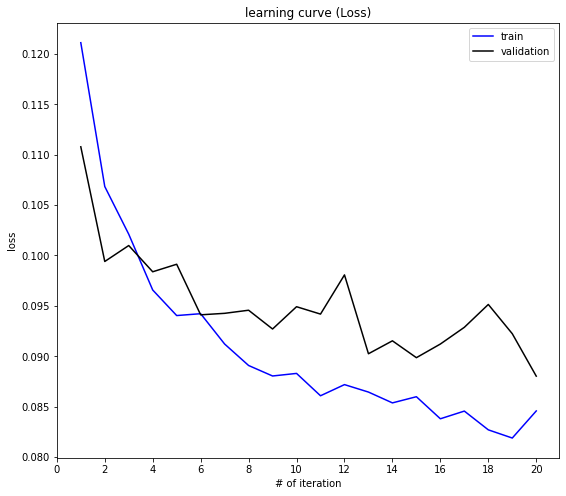

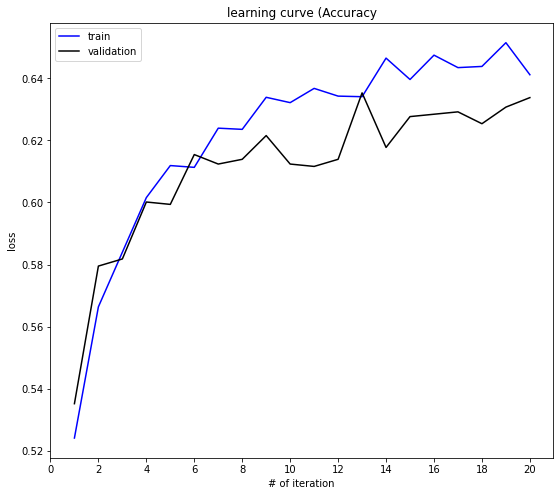

In [26]:
evaluate_history(history)

In [27]:
# Unfreeze the backborn and do training again
for param in model.parameters():
    param.requires_grad = True

In [28]:
# Unfreeze the backborn and do training again
train_dataset = KenyanFood13SplitDataset(transform = train_preprocess(),train = True)
validation_dataset = KenyanFood13SplitDataset(transform = validation_preprocess(), train = False)
sequential_sampler = torch.utils.data.SequentialSampler(train_dataset)
weight_sampler = WeightedRandomSampler(weights=train_dataset.samples_weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, sampler = weight_sampler, batch_size = tc.batch_size, shuffle = False)
validation_loader = DataLoader(validation_dataset, batch_size = tc.batch_size, shuffle = False )
# create optimizer
optimizer = AdamW(model.parameters(), lr=tc.lr)
print(f"length of train_dataset {len(train_dataset.samples_weights)}")

length of train_dataset 5228


In [29]:
# and do training again
best_val_loss = np.Inf
history = np.zeros((0,6))
for epoch in range(tc.epoch_count):
    # time one cycle of train and validate
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, validation_loader)
    elapsed_time = time.time() - start_time
    
    # save the weight when the loss gets smaller than last one
    if val_loss < best_val_loss:
        save_model(model, tc.device)
        print("WEIGHTS-ARE-SAVED")
        best_val_loss = val_loss
        
    print(f"Epoch{epoch+1}/{tc.epoch_count}, loss:{train_loss:.5f}, acc:{train_acc:.5f}, val_loss:{val_loss:.5f}, val_acc:{val_acc:.5f}, elapsed_time:{elapsed_time:.5f}")
    # store 0:epoch, 1:avg_train_loss, 2: avg_train_acc, 3: avg_val_loss, 4: avg_val_acc, 5: elapsed_time
    item = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc, elapsed_time])
    # store history for matplotlib visualization
    history = np.vstack((history, item))

    # For tensorboard
    tc.tb_writer.add_scalar('Loss/Train within {}/{}'.format(epoch+1,tc.epoch_count), train_loss, epoch+1)
    tc.tb_writer.add_scalar('Accuracy/Train within {}/{}'.format(epoch+1,tc.epoch_count), train_acc, epoch+1)
    tc.tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch+1)


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch1/20, loss:0.07362, acc:0.69549, val_loss:0.08309, val_acc:0.66284, elapsed_time:231.12946


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch2/20, loss:0.06980, acc:0.69740, val_loss:0.07853, val_acc:0.66743, elapsed_time:228.73338


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch3/20, loss:0.06410, acc:0.73546, val_loss:0.07642, val_acc:0.70489, elapsed_time:229.83031


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch4/20, loss:0.06058, acc:0.74923, val_loss:0.07579, val_acc:0.70413, elapsed_time:228.42179


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch5/20, loss:0.05725, acc:0.75402, val_loss:0.07477, val_acc:0.70642, elapsed_time:226.62322


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch6/20, loss:0.05312, acc:0.77200, val_loss:0.07395, val_acc:0.71407, elapsed_time:227.24128


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch7/20, loss:0.05099, acc:0.78921, val_loss:0.07335, val_acc:0.71483, elapsed_time:225.12955


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch8/20, loss:0.04865, acc:0.79992, val_loss:0.07130, val_acc:0.72706, elapsed_time:225.69541


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch9/20, loss:0.04531, acc:0.80796, val_loss:0.06961, val_acc:0.73012, elapsed_time:226.50956


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch10/20, loss:0.04546, acc:0.81274, val_loss:0.07071, val_acc:0.71254, elapsed_time:226.27381


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch11/20, loss:0.04494, acc:0.81408, val_loss:0.07042, val_acc:0.72859, elapsed_time:227.22610


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch12/20, loss:0.04196, acc:0.83034, val_loss:0.06919, val_acc:0.73471, elapsed_time:225.73358


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch13/20, loss:0.04386, acc:0.81733, val_loss:0.06892, val_acc:0.73089, elapsed_time:228.23265


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch14/20, loss:0.03926, acc:0.83397, val_loss:0.06955, val_acc:0.73777, elapsed_time:227.48168


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch15/20, loss:0.03616, acc:0.84640, val_loss:0.06801, val_acc:0.74083, elapsed_time:227.44248


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch16/20, loss:0.03631, acc:0.85080, val_loss:0.06782, val_acc:0.75459, elapsed_time:229.47468


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch17/20, loss:0.03563, acc:0.85520, val_loss:0.07104, val_acc:0.73394, elapsed_time:229.01022


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch18/20, loss:0.03425, acc:0.86343, val_loss:0.07197, val_acc:0.73547, elapsed_time:230.88478


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch19/20, loss:0.03234, acc:0.87146, val_loss:0.07082, val_acc:0.72936, elapsed_time:227.84789


  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch20/20, loss:0.03084, acc:0.87070, val_loss:0.07094, val_acc:0.72171, elapsed_time:229.03960


In [30]:
# Now do the inference and get submission.csv file
test_dataset = KenyanFood13Testset()
test_loader = DataLoader(test_dataset, batch_size = tc.batch_size, shuffle = False)

# prediction
predicted_result = predict(model, test_loader)
#print("predicted_result len:{}".format(len(predicted_result)))
classifications = []

#change predicted index to class_names
for index in range(len(predicted_result)):
    predicted_result_class = test_dataset.base_dataset.index2class(int(predicted_result[index]))
    classifications.append(predicted_result_class)

# put it to csv file
classes = pd.DataFrame(classifications, columns = ["class"])
result = test_dataset.test_labels.join(classes)
result.to_csv(tc.submission_csv, index=False, header = True)

In [31]:
# dont use anymore... refactored
# def fit(model, optimizer, train_loader, validation_loader, history):
#     """works like tensorflow fits. epoch_count, optimizer and criterion(e.g., CrossEntorpyLoss) from training config"""
    
#     #from tqdm.notebook import tqdm
    
#     base_epochs = len(history)
    
#     for epoch in range(base_epochs, tc.epoch_count + base_epochs):
#         train_loss = 0
#         train_acc = 0
#         val_loss = 0
#         val_acc = 0
#         best_valid_loss = np.Inf
        
#         # training Phase
#         model.train()
#         count = 0
        
#         t_begin = time.time()
#         for inputs, labels in train_loader:
            
#             count += len(labels)
#             inputs = inputs.to(tc.device)
#             labels = labels.to(tc.device)
            
#             # initialize the gradients
#             optimizer.zero_grad()
#             # predict
#             outputs = model(inputs)
#             # calculate loss
#             loss = tc.criterion(outputs, labels)
#             train_loss += loss.item()
            
#             #calucalte the graidents
#             loss.backward()
#             #update parameter
#             optimizer.step()
            
#             # get highest predicted value
#             predicted = torch.max(outputs, axis=1)[1]
#             # calculate number of correct answer
#             train_acc  += (predicted == labels).sum().item()
            
#             #calculate the average loss and accuracy in the batch
#             avg_train_loss = train_loss / count
#             avg_train_acc = train_acc / count
            
#         #evaluation phase
#         model.eval()
#         count = 0
        
#         for inputs, labels in validation_loader:
#             count += len(labels)
#             inputs = inputs.to(tc.device)
#             labels = labels.to(tc.device)
            
#             # calculate the prediction
#             outputs = model(inputs)
            
#             # calculate the loss
#             loss = tc.criterion(outputs, labels)
#             val_loss += loss.item()
            
#             if val_loss < best_valid_loss:
#                 torch.save(model.state_dict(), "best_model.pt")
#                 print("WEIGHTS-ARE-SAVED")
#                 best_valid_loss = val_loss
                
#             # get highest predicted value
#             predicted = torch.max(outputs, axis=1)[1]
#             # calculate number of correct answer
#             val_acc += (predicted == labels).sum().item()
            
#             #calculate the average loss and accuracy in the batch
#             avg_val_loss = val_loss / count
#             avg_val_acc = val_acc / count
            
            
#         elapsed_time = time.time() - t_begin
#         # print out
#         print("Epoch{}/{},  loss:{:.5f}, acc:{:.5f}, val_loss:{:.5f}, val_acc:{:.5f}, elapsed_time:{:.5f}".format(
#             epoch+1,tc.epoch_count+base_epochs, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, elapsed_time
#         ))
#         # store 0:epoch, 1:avg_train_loss, 2: avg_train_acc, 3: avg_val_loss, 4: avg_val_acc, 5: elapsed_time
#         item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, elapsed_time])
#         history = np.vstack((history, item))
        
#         # For tensorboard
#         tc.tb_writer.add_scalar('Loss/Train within {}/{}'.format(epoch+1,tc.epoch_count+base_epochs), avg_train_loss, epoch+1)
#         tc.tb_writer.add_scalar('Accuracy/Train within {}/{}'.format(epoch+1,tc.epoch_count+base_epochs), avg_train_acc, epoch+1)
#         tc.tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch+1)

        
#     return history

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

/kaggle/working/logs/events.out.tfevents.1676751468.7b40718cd348.24.0


In [ ]:
https://github.com/caq05630

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

https://www.kaggle.com/code/yasuokada/project2/edit/run/119205728